In [1]:
#import libraries
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
#retrieve data
df=pd.read_csv('/kaggle/input/nsei-prev-data/in_nsei_daily.csv',index_col='minute', parse_dates=True)
df.index = df.index.to_pydatetime()
df=pd.DataFrame(df)
df.head

<bound method NDFrame.head of                           ticker    instrument_token      open      high  \
2017-01-02 09:15:00+05:30   NSEI  uf-n-1647516806122   8211.70   8211.70   
2017-01-03 09:15:00+05:30   NSEI  uf-n-1647516806122   8195.25   8219.00   
2017-01-04 09:15:00+05:30   NSEI  uf-n-1647516806122   8201.60   8218.45   
2017-01-05 09:15:00+05:30   NSEI  uf-n-1647516806122   8227.75   8282.55   
2017-01-06 09:15:00+05:30   NSEI  uf-n-1647516806122   8283.50   8306.50   
...                          ...                 ...       ...       ...   
2022-12-26 09:15:00+05:30   NSEI  uf-n-1647516806122  17832.90  18084.10   
2022-12-27 09:15:00+05:30   NSEI  uf-n-1647516806122  18081.90  18149.25   
2022-12-28 09:15:00+05:30   NSEI  uf-n-1647516806122  18093.00  18173.10   
2022-12-29 09:15:00+05:30   NSEI  uf-n-1647516806122  18059.80  18229.70   
2022-12-30 09:15:00+05:30   NSEI  uf-n-1647516806122  18264.70  18265.25   

                                low     close  
2017-01-0

In [3]:
#define the feature columns and target column
features = ['open', 'high', 'low']
target = 'close'

In [4]:
#train/test split
x=df[features]
y=df[target]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [5]:
# create a Ridge regression model
model = Ridge(alpha=0.5)

In [6]:
#fit the model on the training data
model.fit(x_train, y_train)

Ridge(alpha=0.5)

In [7]:
#make predictions on the testing data
y_pred = model.predict(x_test)

In [8]:
#evaluate model's performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("R2 Score:", r2)
print("Mean Squared Error:", mse)

R2 Score: 0.9998192041204527
Mean Squared Error: 1649.7817701818935


In [10]:
#predictions for data
y_pred = model.predict(df[['open','high','low']])

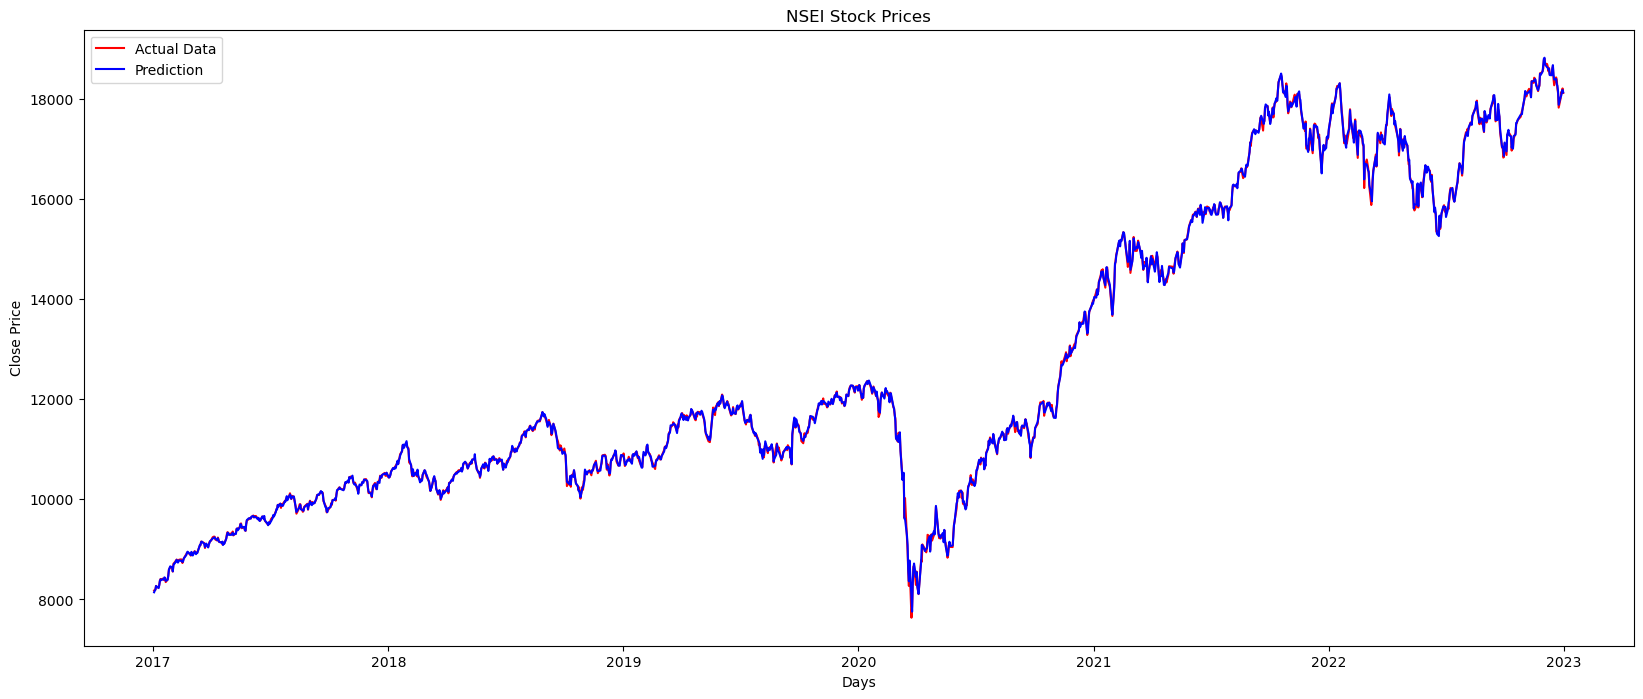

In [11]:
#plotting
plt.rcParams["figure.figsize"] = (20,8)

plt.plot(df.index,df['close'], color = 'red', label="Actual Data")
plt.plot(df.index,y_pred, color='blue', label="Prediction")

plt.title('NSEI Stock Prices')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()